The current proof of concept dataset we use is a bimodal normal distribution.

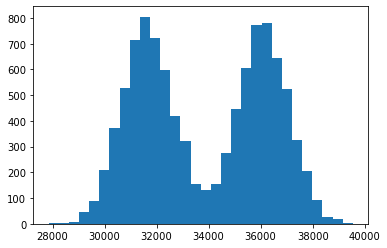

In [3]:
import numpy as np
import matplotlib.pyplot as plt

L = 10000
data = np.abs(np.random.normal(np.sqrt(10)*L, 0.1*L, size=L) \
    + 0.45*L*np.random.randint(2,size=L)).astype(int)

fig, ax = plt.subplots()
ax.hist(data, bins=30)

plt.show()

However, we are interested in index structures, so we only ever the sorted instance of the data, as well as the corresponding index of each observation in sorted order.

[]

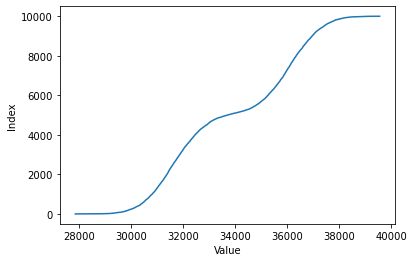

In [4]:
data.sort()

fig, ax = plt.subplots()
ax.plot(data, range(len(data)))
ax.set_xlabel('Value')
ax.set_ylabel('Index')
ax.plot()

Our goal is to approximate the index of a given value. The most straightforward meanas is to approximate this function itself, which we can first do by a linear approximation.

The most straightforward means (though perhaps the best worst option), is to just guess the mean.

In [5]:
from functools import cache

def predmean(data):
    @cache
    def inner(x):
        idxs = range(len(data))
        return sum(idxs) / len(idxs)
    return inner

[]

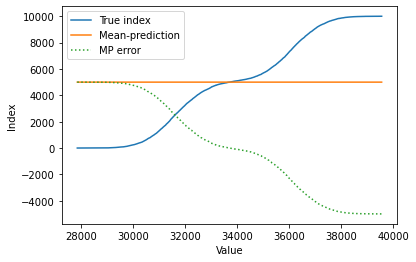

In [6]:
pred = predmean(data)

fig, ax = plt.subplots()
ax.plot(data, range(len(data)), label="True index")

predictions = [pred(x) for x in data]
residuals = [pred(x) - i for i, x in enumerate(data)]

ax.plot(data, predictions, label="Mean-prediction")
ax.plot(data, residuals, ':', label="MP error")
ax.set_xlabel('Value')
ax.set_ylabel('Index')
ax.legend()
ax.plot()

As expected, this is markedly bad performance.
This is the same issue as a B-tree, but even worse; we use no information about the distribution besides the mean.
What if we make use of the shape?

[]

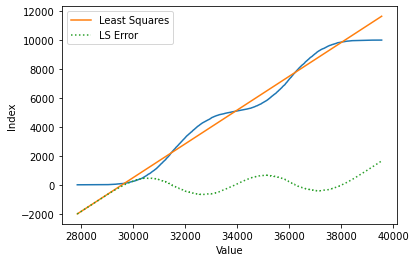

In [7]:
from sklearn.linear_model import LinearRegression

X = np.array([data]).reshape(-1, 1)

def predslr(data):
    regr = LinearRegression()
    regr.fit(data, range(len(data)))
    
    def inner(x):
        return regr.predict(x)
    
    return inner

pred = predslr(X)
predictions = [pred([[x]]) for x in data]
residuals = [x -  i for i, x in enumerate(predictions)]

fig, ax = plt.subplots()
ax.plot(data, range(len(data)))
ax.plot(data, predictions, label="Least Squares")
ax.plot(data, residuals, ':', label="LS Error")
ax.set_xlabel('Value')
ax.set_ylabel('Index')
ax.legend()
ax.plot()

Least squares regression comes with the following guarantee:
> The line minimizies the *sum of squared errors* for each point.

This is a good property on the surface.
We care about predictions, and when we predict the data that was originally in the dataset, the sum of the squares of deviations is minimized.
So, if we have that
- We should penalize the model from from the error that comes from predicting on the data
- More error is bad and should penalize the model.
- Larger deviations from the correct answer consistutes more error.
- The influence of each point is equal.
Then a LSRL seems perfect, since a penalty of
$$\sum_{k \in \text{Keys}} (\hat{p}(k) - p(k))$$
where $\hat{p}$ is the predicted index given by the linear model seems perfect.
However, there were two additional assumptions from using this score that are odd:
- Our model should be a single linear function.
    - We will revisit this soon.
- Our sum of *squared* errors is the total penalty.

Why squared error?

Observe that penalizing by squared error is the same as the mean of squared deviations.
Suppose we have two different functions/models to predict indices, $\hat{p}_1$ and $\hat{p}_2$.
If model 1 is chosen over model $2$, this implies that $\sum_{k \in \text{Keys}} (\hat{p}_1(k) - p(k))^2 < \sum_{k \in \text{Keys}} (\hat{p}_2(k) - p(k))^2$.
Observe that
$$\sum_{k \in \text{Keys}} (\hat{p}_1(k) - p(k))^2 < \sum_{k \in \text{Keys}} (\hat{p}_2(k) - p(k))^2 \implies \frac{\sum_{k \in \text{Keys}} (\hat{p}_1(k) - p(k))^2)}{\lvert \text{Keys} \rvert} < \frac{\sum_{k \in \text{Keys}} (\hat{p}_2(k) - p(k))^2)}{ \lvert \text{Keys} \rvert}$$
We can obtain the mean by dividing over the sum by the number of terms.
So we are selecting a model that minimizes the mean of the square of the deviations.
However, why not simply the mean of the deviations? (To be clear, the absolute value in the deviations).

It turns out that such models are inherently unstable and do not always yield analytic solutions.
Recognizing the error of the model as a cost, we can formulate this as a gradient descent problem, which we will again come back to.

Let's get back to the other assumption, that a single line is a good choice.
There is one distinct advantage:
> We use almost no space.
Indeed, we only need two parameters.
In comparison, a B tree duplicates the entire dataset twice over in memory.

This is clearly a victory in the space party, but one may think that the accuracy suffers.
In truth, accuracy is actually not a true metric on assessment.
Given an estimate, we are informed of search; we can do linear search around the point, or do exponential search around the point, or use this as a initial midpoint for binary search.
How well do we do?


In [27]:
from bisect import bisect_left

def pinch_predict(data, prediction_func):

    def inner(x):
        yhat = prediction_func(x)
        if yhat < 0:
            return 0
        if yhat >= len(data):
            return len(data) - 1
        return yhat
    
    return inner

def informed_bsearch(data, prediction_func):
    
    def inner(x):
        yhat = prediction_func(x)
        if yhat < 0:
            yhat = 0
        if yhat >= len(data):
            yhat = len(data) - 1
        xhat = data[yhat]

        if xhat > x:
            yhat = bisect_left(data, x, 0, yhat)
        elif yhat < x:
            yhat = bisect_left(data, x, yhat, len(data))
            if yhat >= len(data):
                return -1
        return yhat if data[yhat] == x else -1
    
    return inner

def exponential_search(data, prediction_func):

    def inner(x):
        ly = yhat = ry = prediction_func(x)

        if data[yhat] > x:
            i = 1
            while ly > 0 and data[ly] > x:
                ly = yhat - i
                i *= 2
            if ly < 0:
                ly = 0
        elif data[yhat] < x:
            i = 1
            while ry < len(data) and data[ry] < x:
                ry = yhat + i
                i *= 2
            if ry >= len(data):
                ry = len(data) - 1
        yhat = bisect_left(data, x, ly, ry)
        return yhat if data[yhat] == x else -1
    
    return inner
        

In [28]:
lm = LinearRegression()
lm.fit(X, range(len(data)))

predict = pinch_predict(data, lambda x: int(lm.predict([[x]])))
bs = informed_bsearch(data, predict)
es = exponential_search(data, predict)
for i, x in enumerate(data):
    
    b = bs(x)
    e = es(x)
    if data[b] != x or data[e] != x:
        print(f"{b}, {e}, {i}")
        break

This verifies that our method works. Let's now consider the actual speeds, first in construction.

In [31]:
%%timeit

lm = LinearRegression()
lm.fit(X, range(len(data)))

predict = pinch_predict(data, lambda x: int(lm.predict([[x]])))
bs = informed_bsearch(data, predict)
es = exponential_search(data, predict)

1.12 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [52]:
from BTrees.LLBTree import LLBTree

In [43]:
%%timeit
t = LLBTree()
t.update({int(x): 0 for x in data})

1.39 ms ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Build time is slightly quicker for our linear regression, but importantly, the BTrees module uses CPython in part, which really speeds up their building process.

Now we consider prediction speed across the entire dataset.

In [44]:
%%timeit

for x in data:
    bs(x)

303 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit

for x in data:
    es(x)

343 ms ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit

for x in data:
    t[int(x)]


1.44 ms ± 29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Clearly the BTree wins.
In addition, we see informed binary search performs better than exponential search.